# Install Library

[RDKit ](https://github.com/rdkit/rdkit)

[DGL](https://github.com/dmlc/dgl/)

[DGL-LifeSci](https://github.com/awslabs/dgl-lifesci)





In [ ]:
%%capture
!pip install rdkit-pypi
!pip install dgllife
!pip install --pre dgl-cu113 dglgo -f https://data.dgl.ai/wheels-test/repo.html

# Import Library

In [1]:
import dgl 
import torch
import random
import cv2
import torchvision
import pandas as pd
import numpy as np
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

from dgllife.data import SIDER 
from numpy import array
from numpy import argmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import  History
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, AttentiveFPAtomFeaturizer
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split

from utils.general import DATASET, get_dataset, separate_active_and_inactive_data,
from utils.general import  get_embedding_vector_class, count_lablel,data_generator
from utils.gcn_pre_trained import get_sider_model

from model.heterogeneous_siamese_sider import siamese_model_attentiveFp_sider, siamese_model_Canonical_sider


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data

In [ ]:
cache_path='./sider_dglgraph.bin'

df = get_dataset("sider")

In [4]:
sider_tasks = df.columns.values[1:].tolist()

In [5]:
from collections import Counter

one = []
zero = []

for task in sider_tasks:
  data = df[task]
  print(task ,":" ,Counter(data))
  zero.append(Counter(data)[0])
  one.append(Counter(data)[1])

Hepatobiliary disorders : Counter({1: 743, 0: 684})
Metabolism and nutrition disorders : Counter({1: 996, 0: 431})
Product issues : Counter({0: 1405, 1: 22})
Eye disorders : Counter({1: 876, 0: 551})
Investigations : Counter({1: 1151, 0: 276})
Musculoskeletal and connective tissue disorders : Counter({1: 997, 0: 430})
Gastrointestinal disorders : Counter({1: 1298, 0: 129})
Social circumstances : Counter({0: 1176, 1: 251})
Immune system disorders : Counter({1: 1024, 0: 403})
Reproductive system and breast disorders : Counter({1: 727, 0: 700})
Neoplasms benign, malignant and unspecified (incl cysts and polyps) : Counter({0: 1051, 1: 376})
General disorders and administration site conditions : Counter({1: 1292, 0: 135})
Endocrine disorders : Counter({0: 1104, 1: 323})
Surgical and medical procedures : Counter({0: 1214, 1: 213})
Vascular disorders : Counter({1: 1108, 0: 319})
Blood and lymphatic system disorders : Counter({1: 885, 0: 542})
Skin and subcutaneous tissue disorders : Counter({

In [6]:
sum(one), sum(zero)

(21868, 16661)

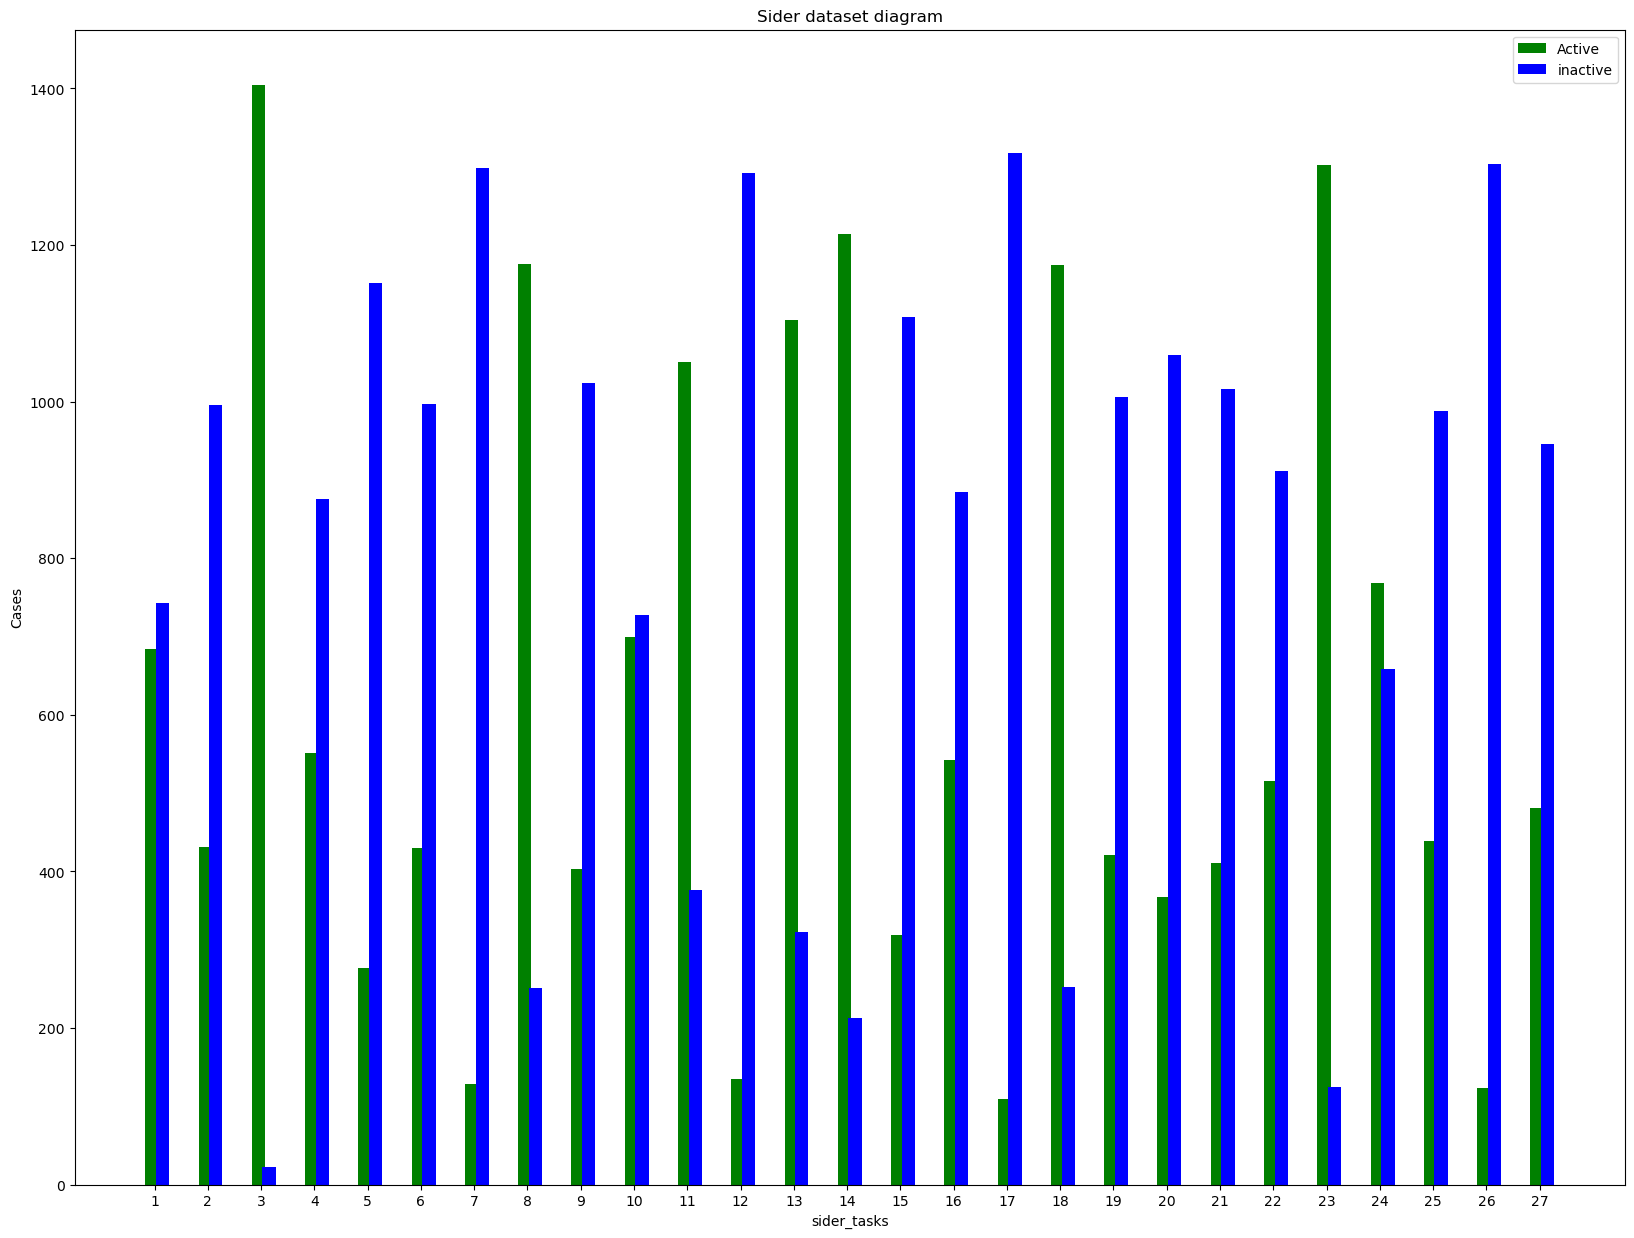

In [7]:
# Importing the matplotlib library
import numpy as np
import matplotlib.pyplot as plt
# Declaring the figure or the plot (y, x) or (width, height)
plt.figure(figsize=[20, 15])
# Data to be plotted
X = np.arange(1,len(sider_tasks)+1)

plt.bar(X + 0.20, zero, color = 'g', width = 0.25)
plt.bar(X + 0.4, one, color = 'b', width = 0.25)
# Creating the legend of the bars in the plot
plt.legend(['Active' , 'inactive' ])
# Overiding the x axis with the country names
plt.xticks([i + 0.25 for i in range(1,28)], X)
# Giving the tilte for the plot
plt.title("Sider dataset diagram")
# Namimg the x and y axis
plt.xlabel('sider_tasks')
plt.ylabel('Cases')
# Saving the plot as a 'png'
plt.savefig('4BarPlot.png')
# Displaying the bar plot
plt.show()

# Required functions

In [60]:
from dgllife.model import MLPPredictor

def create_dataset_with_gcn(dataset, class_embed_vector, GCN, tasks ):
    created_data = []
    data = np.arange(len(tasks))
    onehot_encoded = to_categorical(data)
    for i, data in enumerate(dataset):
        smiles, g, labels, mask = data
        g = g.to(device)
        g = dgl.add_self_loop(g)
        graph_feats = g.ndata.pop('h')
        embbed = GCN(g, graph_feats)
        embbed = embbed.to('cpu')
        embbed = embbed.detach().numpy()
        for j, label in enumerate(labels):
            a = (embbed, onehot_encoded[j], class_embed_vector[j], label, j , tasks[j])
            created_data.append(a)
    print('Data created!!')
    return created_data

# Calculation of embedded vectors for each class

In [10]:
df_positive, df_negative = Separate_active_and_inactive_data(df, sider_tasks)

for i,d in enumerate(zip(df_positive,df_negative)):
    print(f'{sider_tasks[i]}=> positive: {len(d[0])} - negative: {len(d[1])}')

Hepatobiliary disorders=> positive: 743 - negative: 684
Metabolism and nutrition disorders=> positive: 996 - negative: 431
Product issues=> positive: 22 - negative: 1405
Eye disorders=> positive: 876 - negative: 551
Investigations=> positive: 1151 - negative: 276
Musculoskeletal and connective tissue disorders=> positive: 997 - negative: 430
Gastrointestinal disorders=> positive: 1298 - negative: 129
Social circumstances=> positive: 251 - negative: 1176
Immune system disorders=> positive: 1024 - negative: 403
Reproductive system and breast disorders=> positive: 727 - negative: 700
Neoplasms benign, malignant and unspecified (incl cysts and polyps)=> positive: 376 - negative: 1051
General disorders and administration site conditions=> positive: 1292 - negative: 135
Endocrine disorders=> positive: 323 - negative: 1104
Surgical and medical procedures=> positive: 213 - negative: 1214
Vascular disorders=> positive: 1108 - negative: 319
Blood and lymphatic system disorders=> positive: 885 - 

In [11]:
dataset_positive = [DATASET(d,smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_positive]
dataset_negative = [DATASET(d,smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_negative]

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1151
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1298
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1024
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1292
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1108
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1318
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1006
Processing dgl graphs from scratch...
Processing molecule 1000/1060


In [12]:
embed_class_sider = get_embedding_vector_class(dataset_positive, dataset_negative, radius=2, size = 512)

class vector created!!


# Classification with BioAct-Het and AttentiveFp GCN

In [55]:
model_name = 'GCN_attentivefp_SIDER'
gcn_model = get_sider_model(model_name)
gcn_model.eval()
gcn_model = gcn_model.to(device)

Pretrained model loaded


In [56]:
dataset = DATASET(df,smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) 
data_ds = create_dataset_with_gcn(dataset, embed_class_sider, gcn_model, sider_tasks)

Processing dgl graphs from scratch...
Processing molecule 1000/1427
Data created!!


In [23]:
from sklearn.model_selection import KFold

Epoch_S = 10

def evaluate_model(df, k = 10 , shuffle = False):
    
    result = [] 
    s = 0

    kf = KFold(n_splits=10, shuffle= shuffle, random_state=None)
    
    for train_index, test_index in kf.split(df):

        train_ds = [df[index] for index in train_index] 
        
        valid_ds = [df[index] for index in test_index]
        
        label_pos , label_neg = count_lablel(train_ds)
        print(f'train positive label: {label_pos} - train negative label: {label_neg}')

        label_pos , label_neg = count_lablel(valid_ds)
        print(f'Test positive label: {label_pos} - Test negative label: {label_neg}')

        l_train = []
        r_train = []
        lbls_train = []
        l_valid = []
        r_valid = []
        lbls_valid = []

        for i , data in enumerate(train_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_train.append(embbed_drug[0])
            r_train.append(embbed_task)
            lbls_train.append(lbl.tolist())
        
        for i , data in enumerate(valid_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_valid.append(embbed_drug[0])
            r_valid.append(embbed_task)
            lbls_valid.append(lbl.tolist())

        l_train = np.array(l_train).reshape(-1,1024,1)
        r_train = np.array(r_train).reshape(-1,512,1)
        lbls_train = np.array(lbls_train)

        l_valid = np.array(l_valid).reshape(-1,1024,1)
        r_valid = np.array(r_valid).reshape(-1,512,1)
        lbls_valid = np.array(lbls_valid)

        # create neural network model
        siamese_net = siamese_model_attentiveFp_sider()
        history = History()
        P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])

        for j in range(100):
            C=1
            Before = int(P.history['accuracy'][-1]*100)
            for i in range(2,Epoch_S+1):
                if  int(P.history['accuracy'][-i]*100) == Before:
                    C=C+1
                else:
                    C=1
                Before=int(P.history['accuracy'][-i]*100)
                print(Before)
            if C==Epoch_S:
                break
            P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])
        print(j+1)
        
        score  = siamese_net.evaluate([l_valid,r_valid], lbls_valid, verbose=1)
        a = (score[1],score[4])
        result.append(a)
        
        if score[4] > s :
            best_model = siamese_net
            s = score[4]
            print("Save_model")
            
        
    return result , best_model

scores, best_model = evaluate_model(data_ds, 10, True)

train positive label: 19695 - train negative label: 14981
Test positive label: 2173 - Test negative label: 1680
Epoch 1/10
271/271 [==============================] - 3s 11ms/step - loss: 0.5390 - accuracy: 0.7325 - mae: 0.3570 - mse: 0.1789 - auc_3: 0.8005
Epoch 2/10
271/271 [==============================] - 3s 11ms/step - loss: 0.4693 - accuracy: 0.7877 - mae: 0.3047 - mse: 0.1511 - auc_3: 0.8581
Epoch 3/10
271/271 [==============================] - 3s 11ms/step - loss: 0.4438 - accuracy: 0.8001 - mae: 0.2871 - mse: 0.1420 - auc_3: 0.8747
Epoch 4/10
271/271 [==============================] - 3s 11ms/step - loss: 0.4308 - accuracy: 0.8067 - mae: 0.2783 - mse: 0.1375 - auc_3: 0.8824
Epoch 5/10
271/271 [==============================] - 3s 11ms/step - loss: 0.4181 - accuracy: 0.8100 - mae: 0.2698 - mse: 0.1337 - auc_3: 0.8891
Epoch 6/10
271/271 [==============================] - 3s 11ms/step - loss: 0.4121 - accuracy: 0.8138 - mae: 0.2650 - mse: 0.1308 - auc_3: 0.8935
Epoch 7/10
271/271

Epoch 4/10
271/271 [==============================] - 3s 10ms/step - loss: 0.3774 - accuracy: 0.8297 - mae: 0.2418 - mse: 0.1199 - auc_4: 0.9102
Epoch 5/10
271/271 [==============================] - 3s 10ms/step - loss: 0.3747 - accuracy: 0.8295 - mae: 0.2400 - mse: 0.1190 - auc_4: 0.9115
Epoch 6/10
271/271 [==============================] - 3s 10ms/step - loss: 0.3717 - accuracy: 0.8313 - mae: 0.2383 - mse: 0.1183 - auc_4: 0.9125
Epoch 7/10
271/271 [==============================] - 3s 10ms/step - loss: 0.3683 - accuracy: 0.8345 - mae: 0.2357 - mse: 0.1169 - auc_4: 0.9144
Epoch 8/10
271/271 [==============================] - 3s 11ms/step - loss: 0.3666 - accuracy: 0.8341 - mae: 0.2346 - mse: 0.1162 - auc_4: 0.9156
Epoch 9/10
271/271 [==============================] - 3s 11ms/step - loss: 0.3632 - accuracy: 0.8361 - mae: 0.2316 - mse: 0.1149 - auc_4: 0.9173
Epoch 10/10
271/271 [==============================] - 3s 11ms/step - loss: 0.3609 - accuracy: 0.8380 - mae: 0.2300 - mse: 0.1144 

271/271 [==============================] - 3s 11ms/step - loss: 0.2920 - accuracy: 0.8659 - mae: 0.1873 - mse: 0.0931 - auc_5: 0.9458
Epoch 3/10
271/271 [==============================] - 3s 11ms/step - loss: 0.2914 - accuracy: 0.8676 - mae: 0.1862 - mse: 0.0929 - auc_5: 0.9460
Epoch 4/10
271/271 [==============================] - 3s 11ms/step - loss: 0.2908 - accuracy: 0.8653 - mae: 0.1865 - mse: 0.0930 - auc_5: 0.9461
Epoch 5/10
271/271 [==============================] - 3s 11ms/step - loss: 0.2869 - accuracy: 0.8665 - mae: 0.1841 - mse: 0.0918 - auc_5: 0.9473
Epoch 6/10
271/271 [==============================] - 3s 11ms/step - loss: 0.2926 - accuracy: 0.8653 - mae: 0.1872 - mse: 0.0932 - auc_5: 0.9456
Epoch 7/10
271/271 [==============================] - 3s 11ms/step - loss: 0.2893 - accuracy: 0.8664 - mae: 0.1858 - mse: 0.0923 - auc_5: 0.9469
Epoch 8/10
271/271 [==============================] - 3s 11ms/step - loss: 0.2891 - accuracy: 0.8675 - mae: 0.1859 - mse: 0.0924 - auc_5: 0.9

271/271 [==============================] - 3s 11ms/step - loss: 0.3714 - accuracy: 0.8315 - mae: 0.2381 - mse: 0.1184 - auc_8: 0.9125
Epoch 8/10
271/271 [==============================] - 3s 11ms/step - loss: 0.3695 - accuracy: 0.8318 - mae: 0.2370 - mse: 0.1176 - auc_8: 0.9136
Epoch 9/10
271/271 [==============================] - 3s 11ms/step - loss: 0.3650 - accuracy: 0.8340 - mae: 0.2337 - mse: 0.1161 - auc_8: 0.9157
Epoch 10/10
271/271 [==============================] - 3s 11ms/step - loss: 0.3643 - accuracy: 0.8350 - mae: 0.2334 - mse: 0.1155 - auc_8: 0.9163
83
83
83
82
82
82
82
82
82
Epoch 1/10
271/271 [==============================] - 3s 11ms/step - loss: 0.3658 - accuracy: 0.8324 - mae: 0.2336 - mse: 0.1161 - auc_8: 0.9156
Epoch 2/10
271/271 [==============================] - 3s 11ms/step - loss: 0.3602 - accuracy: 0.8368 - mae: 0.2304 - mse: 0.1144 - auc_8: 0.9181
Epoch 3/10
271/271 [==============================] - 3s 11ms/step - loss: 0.3601 - accuracy: 0.8364 - mae: 0.230

271/271 [==============================] - 3s 11ms/step - loss: 0.3250 - accuracy: 0.8528 - mae: 0.2085 - mse: 0.1032 - auc_9: 0.9333
Epoch 6/10
271/271 [==============================] - 3s 11ms/step - loss: 0.3255 - accuracy: 0.8506 - mae: 0.2087 - mse: 0.1036 - auc_9: 0.9331
Epoch 7/10
271/271 [==============================] - 3s 11ms/step - loss: 0.3252 - accuracy: 0.8505 - mae: 0.2077 - mse: 0.1033 - auc_9: 0.9333
Epoch 8/10
271/271 [==============================] - 3s 11ms/step - loss: 0.3251 - accuracy: 0.8519 - mae: 0.2077 - mse: 0.1030 - auc_9: 0.9337
Epoch 9/10
271/271 [==============================] - 3s 11ms/step - loss: 0.3255 - accuracy: 0.8501 - mae: 0.2082 - mse: 0.1034 - auc_9: 0.9333
Epoch 10/10
271/271 [==============================] - 3s 10ms/step - loss: 0.3211 - accuracy: 0.8524 - mae: 0.2052 - mse: 0.1018 - auc_9: 0.9351
85
85
85
85
85
84
84
84
84
Epoch 1/10
271/271 [==============================] - 3s 11ms/step - loss: 0.3210 - accuracy: 0.8530 - mae: 0.205

271/271 [==============================] - 4s 13ms/step - loss: 0.3971 - accuracy: 0.8163 - mae: 0.2557 - mse: 0.1269 - auc_12: 0.9000
Epoch 10/10
271/271 [==============================] - 4s 13ms/step - loss: 0.3919 - accuracy: 0.8204 - mae: 0.2521 - mse: 0.1253 - auc_12: 0.9023
81
81
81
81
80
80
79
78
72
Epoch 1/10
271/271 [==============================] - 4s 13ms/step - loss: 0.3914 - accuracy: 0.8220 - mae: 0.2513 - mse: 0.1247 - auc_12: 0.9035
Epoch 2/10
271/271 [==============================] - 4s 13ms/step - loss: 0.3853 - accuracy: 0.8233 - mae: 0.2481 - mse: 0.1233 - auc_12: 0.9055
Epoch 3/10
271/271 [==============================] - 4s 13ms/step - loss: 0.3831 - accuracy: 0.8253 - mae: 0.2470 - mse: 0.1221 - auc_12: 0.9074
Epoch 4/10
271/271 [==============================] - 4s 13ms/step - loss: 0.3801 - accuracy: 0.8264 - mae: 0.2444 - mse: 0.1215 - auc_12: 0.9082
Epoch 5/10
271/271 [==============================] - 4s 13ms/step - loss: 0.3772 - accuracy: 0.8270 - mae:

271/271 [==============================] - 3s 13ms/step - loss: 0.3001 - accuracy: 0.8597 - mae: 0.1931 - mse: 0.0960 - auc_12: 0.9426
Epoch 5/10
271/271 [==============================] - 4s 13ms/step - loss: 0.3002 - accuracy: 0.8592 - mae: 0.1935 - mse: 0.0964 - auc_12: 0.9424
Epoch 6/10
271/271 [==============================] - 3s 13ms/step - loss: 0.2979 - accuracy: 0.8599 - mae: 0.1919 - mse: 0.0955 - auc_12: 0.9432
Epoch 7/10
271/271 [==============================] - 3s 13ms/step - loss: 0.2967 - accuracy: 0.8616 - mae: 0.1903 - mse: 0.0950 - auc_12: 0.9439
Epoch 8/10
271/271 [==============================] - 3s 13ms/step - loss: 0.2930 - accuracy: 0.8615 - mae: 0.1886 - mse: 0.0939 - auc_12: 0.9451
Epoch 9/10
271/271 [==============================] - 4s 13ms/step - loss: 0.2942 - accuracy: 0.8618 - mae: 0.1901 - mse: 0.0946 - auc_12: 0.9445
Epoch 10/10
271/271 [==============================] - 3s 13ms/step - loss: 0.2949 - accuracy: 0.8624 - mae: 0.1888 - mse: 0.0940 - auc

In [260]:
l_train = []
r_train = []
lbls_train = []
task_number_train = []

l_valid = []
r_valid = []
lbls_valid = []
task_namber_test = []

for i , data in enumerate(train_ds):
    embbed_drug, onehot_task, embbed_task, lbl, task_number, task_name = data
    if lbl == 1.:
        l_train.append(embbed_drug[0])
        r_train.append(embbed_task)
        lbls_train.append(lbl.tolist())
        task_number_train.append(task_number)


for i, data in enumerate(valid_ds):
    embbed_drug, onehot_task, embbed_task, lbl, task_number, task_name = data
    if lbl == 1.:   
        l_valid.append(embbed_drug[0])
        r_valid.append(embbed_task)
        lbls_valid.append(lbl.tolist())
        task_namber_test.append(task_number)

l_train = np.array(l_train).reshape(-1,1024,1)
r_train = np.array(r_train).reshape(-1,512,1)
lbls_train = np.array(lbls_train)

l_valid = np.array(l_valid).reshape(-1,1024,1)
r_valid = np.array(r_valid).reshape(-1,512,1)
lbls_valid = np.array(lbls_valid)

In [270]:
model = siamese_model()

# Train the siamese model with your training data

# Create a new Keras model that outputs the output of the L1 layer in the siamese model
L1_model = tf.keras.Model(inputs=model.inputs,
                          outputs=model.layers[5].output)

# Get the output of the L1 layer for the test data
before_training_L1_output_valid = L1_model.predict([l_valid, r_valid])
before_training_L1_output_train = L1_model.predict([l_train, r_train])

In [271]:
# Train the siamese model with your training data

# Create a new Keras model that outputs the output of the L1 layer in the siamese model
L1_model = tf.keras.Model(inputs=best_model.inputs,
                          outputs=best_model.layers[5].output)

# Get the output of the L1 layer for the test data
after_training_L1_output_valid = L1_model.predict([l_valid, r_valid])
after_training_L1_output_train = L1_model.predict([l_train, r_train])

### T-SNE Visualization n_components = 3 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17536 samples in 0.001s...
[t-SNE] Computed neighbors for 17536 samples in 4.918s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17536
[t-SNE] Computed conditional probabilities for sample 2000 / 17536
[t-SNE] Computed conditional probabilities for sample 3000 / 17536
[t-SNE] Computed conditional probabilities for sample 4000 / 17536
[t-SNE] Computed conditional probabilities for sample 5000 / 17536
[t-SNE] Computed conditional probabilities for sample 6000 / 17536
[t-SNE] Computed conditional probabilities for sample 7000 / 17536
[t-SNE] Computed conditional probabilities for sample 8000 / 17536
[t-SNE] Computed conditional probabilities for sample 9000 / 17536
[t-SNE] Computed conditional probabilities for sample 10000 / 17536
[t-SNE] Computed conditional probabilities for sample 11000 / 17536
[t-SNE] Computed conditional probabilities for sample 12000 / 17536
[t-SNE] Computed conditional probabilities for sam

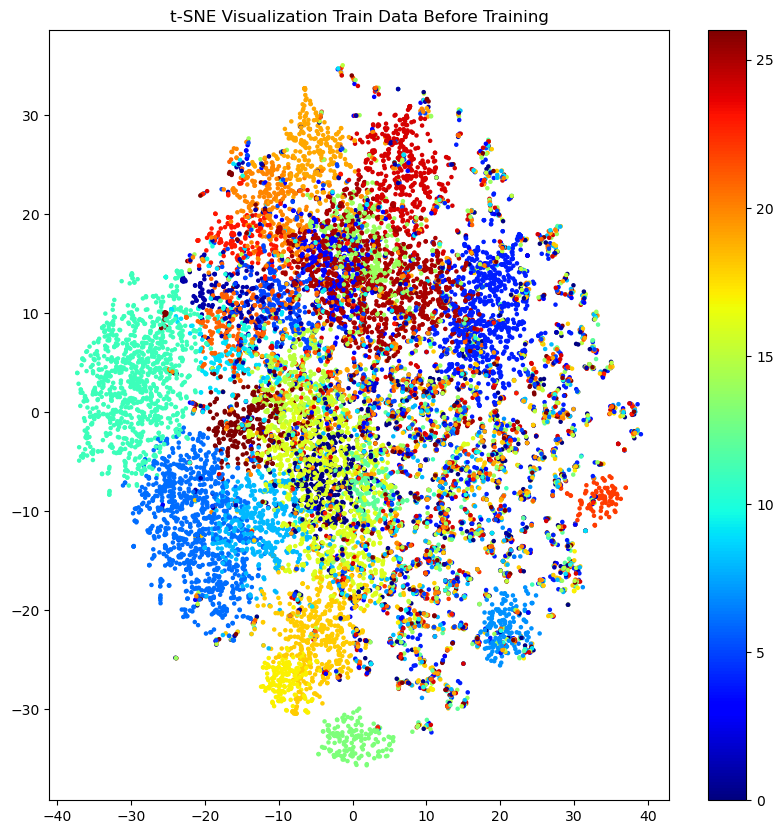

In [280]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load your data
data = before_training_L1_output_train.copy()  # Replace this with your actual data
labels = task_number_train.copy()

# Define the t-SNE model with default parameters
tsne = TSNE(n_components=3, init='random', learning_rate=200.0, verbose=1)

# Fit and transform the data to 2 dimensions
tsne_result = tsne.fit_transform(data)

# Plot the t-SNE results
plt.figure(figsize=(10, 10))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='jet', s=5)
plt.colorbar()
plt.title('t-SNE Visualization Train Data Before Training')
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17536 samples in 0.002s...
[t-SNE] Computed neighbors for 17536 samples in 5.530s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17536
[t-SNE] Computed conditional probabilities for sample 2000 / 17536
[t-SNE] Computed conditional probabilities for sample 3000 / 17536
[t-SNE] Computed conditional probabilities for sample 4000 / 17536
[t-SNE] Computed conditional probabilities for sample 5000 / 17536
[t-SNE] Computed conditional probabilities for sample 6000 / 17536
[t-SNE] Computed conditional probabilities for sample 7000 / 17536
[t-SNE] Computed conditional probabilities for sample 8000 / 17536
[t-SNE] Computed conditional probabilities for sample 9000 / 17536
[t-SNE] Computed conditional probabilities for sample 10000 / 17536
[t-SNE] Computed conditional probabilities for sample 11000 / 17536
[t-SNE] Computed conditional probabilities for sample 12000 / 17536
[t-SNE] Computed conditional probabilities for sam

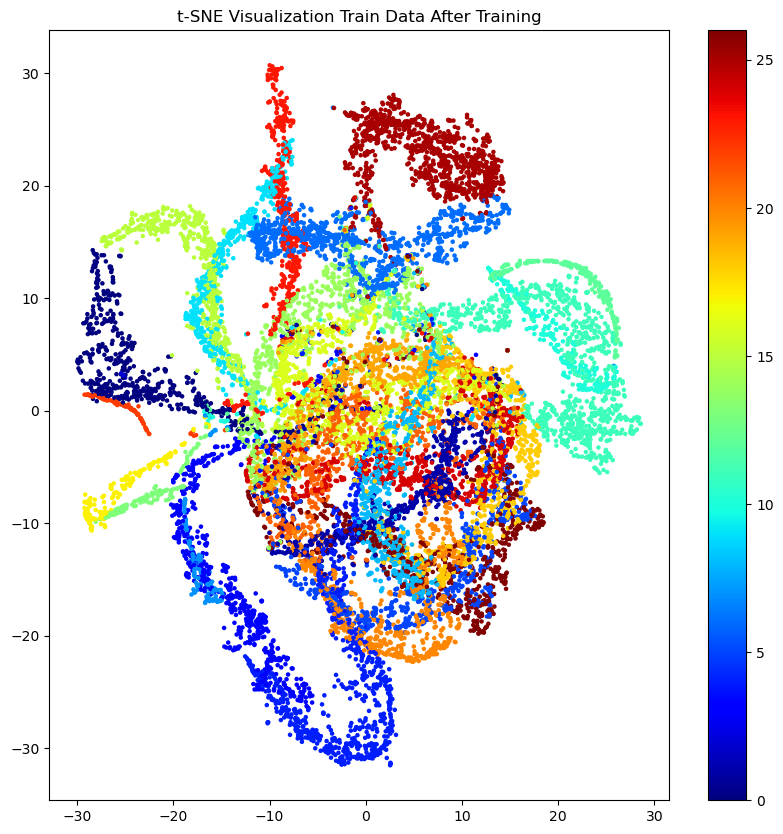

In [281]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load your data
data = after_training_L1_output_train.copy()  # Replace this with your actual data
labels = task_number_train.copy()

# Define the t-SNE model with default parameters
tsne = TSNE(n_components=3, init='random', learning_rate=200.0, verbose=1)

# Fit and transform the data to 2 dimensions
tsne_result = tsne.fit_transform(data)

# Plot the t-SNE results
plt.figure(figsize=(10, 10))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='jet', s=5)
plt.colorbar()
plt.title('t-SNE Visualization Train Data After Training')
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4332 samples in 0.001s...
[t-SNE] Computed neighbors for 4332 samples in 0.354s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4332
[t-SNE] Computed conditional probabilities for sample 2000 / 4332
[t-SNE] Computed conditional probabilities for sample 3000 / 4332
[t-SNE] Computed conditional probabilities for sample 4000 / 4332
[t-SNE] Computed conditional probabilities for sample 4332 / 4332
[t-SNE] Mean sigma: 0.679560
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.239075
[t-SNE] KL divergence after 1000 iterations: 1.252108


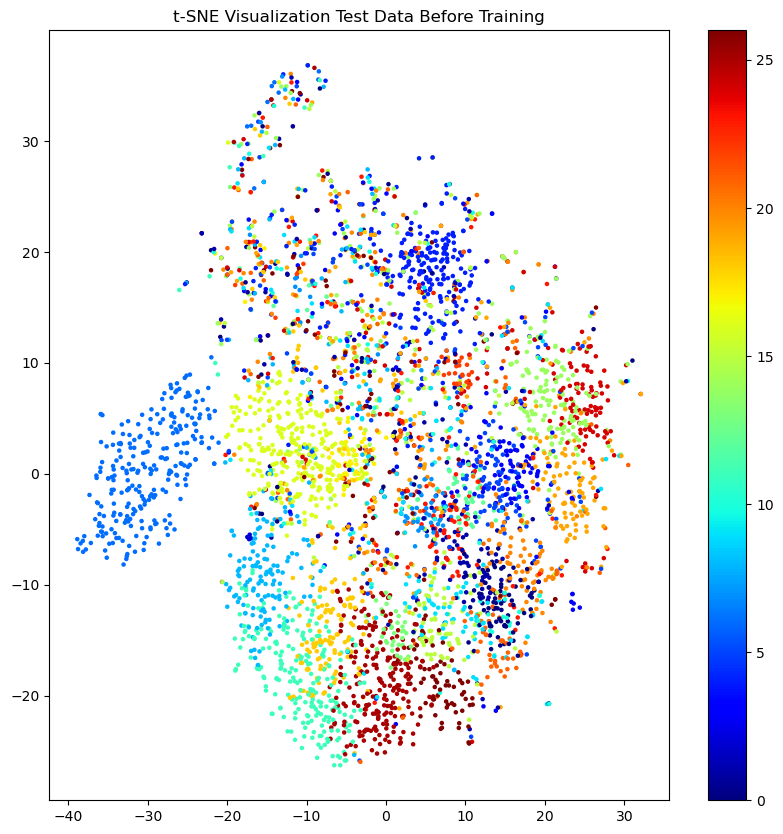

In [282]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load your data
data = before_training_L1_output_valid.copy()  # Replace this with your actual data
labels = task_namber_test.copy()

# Define the t-SNE model with default parameters
tsne = TSNE(n_components=3, init='random', learning_rate=200.0, verbose=1)

# Fit and transform the data to 2 dimensions
tsne_result = tsne.fit_transform(data)

# Plot the t-SNE results
plt.figure(figsize=(10, 10))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='jet', s=5)
plt.colorbar()
plt.title('t-SNE Visualization Test Data Before Training')
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4332 samples in 0.000s...
[t-SNE] Computed neighbors for 4332 samples in 0.320s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4332
[t-SNE] Computed conditional probabilities for sample 2000 / 4332
[t-SNE] Computed conditional probabilities for sample 3000 / 4332
[t-SNE] Computed conditional probabilities for sample 4000 / 4332
[t-SNE] Computed conditional probabilities for sample 4332 / 4332
[t-SNE] Mean sigma: 22.047310
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.346729
[t-SNE] KL divergence after 1000 iterations: 0.511527


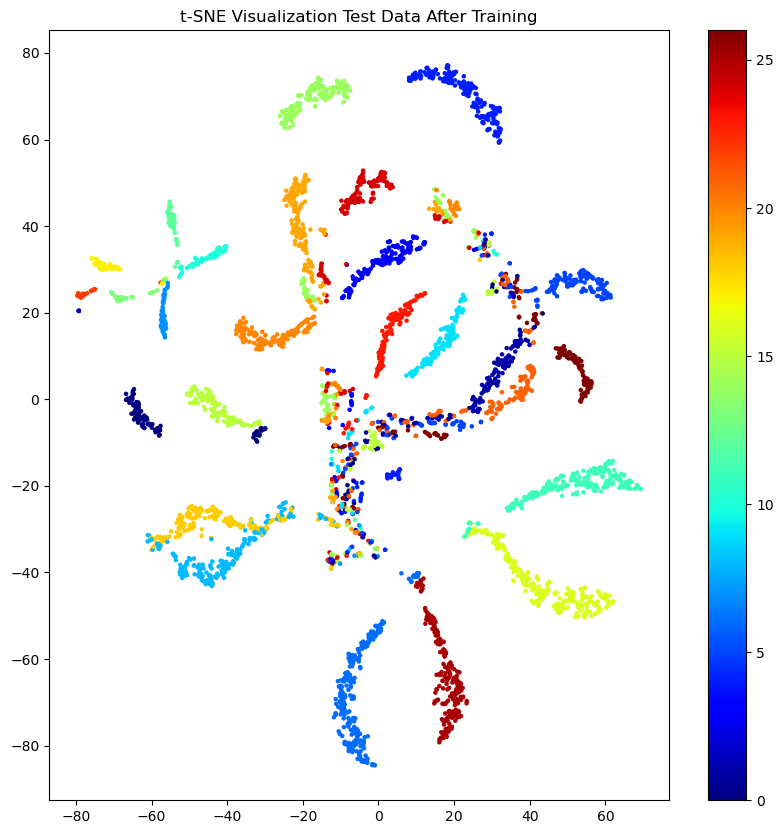

In [283]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load your data
data = after_training_L1_output_valid.copy()  # Replace this with your actual data
labels = task_namber_test.copy()

# Define the t-SNE model with default parameters
tsne = TSNE(n_components=2, init='random', learning_rate=200.0, verbose=1)

# Fit and transform the data to 2 dimensions
tsne_result = tsne.fit_transform(data)

# Plot the t-SNE results
plt.figure(figsize=(10, 10))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='jet', s=5)
plt.colorbar()
plt.title('t-SNE Visualization Test Data After Training')
plt.show()

### radius = 2, size = 512,  epochs = 10, bach = 128

In [22]:
scores

[(0.8261095285415649, 0.9137550592422485),
 (0.8274072408676147, 0.9117997884750366),
 (0.8300026059150696, 0.9103667140007019),
 (0.8198806047439575, 0.9039552211761475),
 (0.8266286253929138, 0.9148426651954651),
 (0.8188424706459045, 0.9063941836357117),
 (0.8359719514846802, 0.9081689119338989),
 (0.8416817784309387, 0.9241073727607727),
 (0.8305216431617737, 0.9116851687431335),
 (0.829958438873291, 0.9069167971611023)]

In [23]:
acc = []
auc = []
for i in scores:
    acc.append(i[0])
    auc.append(i[1])
print(f'accuracy= {np.mean(acc)} AUC= {np.mean(auc)}')

accuracy= 0.8287004888057709 AUC= 0.9111991882324219


# Classification with BioAct-Het and Canonical GCN 

In [24]:
model_name = 'GCN_canonical_SIDER'
gcn_model = get_sider_model(model_name)
gcn_model.eval()
gcn_model = gcn_model.to(device)

Pretrained model loaded


In [25]:
dataset = DATASET(df,smiles_to_bigraph, CanonicalAtomFeaturizer(), cache_file_path = cache_path) 
data_ds = create_dataset_with_gcn(dataset, embed_class_sider, gcn_model, sider_tasks)

Processing dgl graphs from scratch...
Processing molecule 1000/1427
Data created!!


In [27]:
from sklearn.model_selection import KFold

Epoch_S = 10

def evaluate_model(df, k = 10 , shuffle = False):
    result =[]    

    kf = KFold(n_splits=10, shuffle= shuffle, random_state=None)
    
    for train_index, test_index in kf.split(df):

        train_ds = [df[index] for index in train_index] 
        
        valid_ds = [df[index] for index in test_index] 
        
        label_pos , label_neg = count_lablel(train_ds)
        print(f'train positive label: {label_pos} - train negative label: {label_neg}')

        label_pos , label_neg = count_lablel(valid_ds)
        print(f'Test positive label: {label_pos} - Test negative label: {label_neg}')

        l_train = []
        r_train = []
        lbls_train = []
        l_valid = []
        r_valid = []
        lbls_valid = []

        for i , data in enumerate(train_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_train.append(embbed_drug[0])
            r_train.append(embbed_task)
            lbls_train.append(lbl.tolist())
        
        for i , data in enumerate(valid_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_valid.append(embbed_drug[0])
            r_valid.append(embbed_task)
            lbls_valid.append(lbl.tolist())

        l_train = np.array(l_train).reshape(-1,512,1)
        r_train = np.array(r_train).reshape(-1,512,1)
        lbls_train = np.array(lbls_train)

        l_valid = np.array(l_valid).reshape(-1,512,1)
        r_valid = np.array(r_valid).reshape(-1,512,1)
        lbls_valid = np.array(lbls_valid)

        # create neural network model
        siamese_net = siamese_model_Canonical_sider()
        history = History()
        P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size=64, callbacks=[history])

        for j in range(100):
            C=1
            Before = int(P.history['accuracy'][-1]*100)
            for i in range(2,Epoch_S+1):
                if  int(P.history['accuracy'][-i]*100)== Before:
                    C=C+1
                else:
                    C=1
                Before=int(P.history['accuracy'][-i]*100)
                print(Before)
            if C==Epoch_S:
                break
            P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size=64, callbacks=[history])

        print(j+1)
        
        score  = siamese_net.evaluate([l_valid,r_valid],lbls_valid, verbose=1)
        a = (score[1],score[4])
        result.append(a)
    
    return result
 

scores = evaluate_model(data_ds, 10, True)

train positive label: 19677 - train negative label: 14999
Test positive label: 2191 - Test negative label: 1662
Epoch 1/10
542/542 [==============================] - 3s 5ms/step - loss: 0.5389 - accuracy: 0.7422 - mae: 0.3600 - mse: 0.1792 - auc_10: 0.7944
Epoch 2/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4938 - accuracy: 0.7732 - mae: 0.3237 - mse: 0.1613 - auc_10: 0.8356
Epoch 3/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4832 - accuracy: 0.7794 - mae: 0.3170 - mse: 0.1576 - auc_10: 0.8430
Epoch 4/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4787 - accuracy: 0.7785 - mae: 0.3133 - mse: 0.1560 - auc_10: 0.8461
Epoch 5/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4733 - accuracy: 0.7820 - mae: 0.3099 - mse: 0.1538 - auc_10: 0.8505
Epoch 6/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4696 - accuracy: 0.7834 - mae: 0.3066 - mse: 0.1526 - auc_10: 0.8530
Epoch 7/10
542/542

542/542 [==============================] - 2s 4ms/step - loss: 0.4762 - accuracy: 0.7794 - mae: 0.3113 - mse: 0.1550 - auc_12: 0.8492
Epoch 5/10
542/542 [==============================] - 2s 4ms/step - loss: 0.4705 - accuracy: 0.7835 - mae: 0.3071 - mse: 0.1527 - auc_12: 0.8534
Epoch 6/10
542/542 [==============================] - 2s 4ms/step - loss: 0.4673 - accuracy: 0.7840 - mae: 0.3048 - mse: 0.1514 - auc_12: 0.8559
Epoch 7/10
542/542 [==============================] - 2s 4ms/step - loss: 0.4626 - accuracy: 0.7847 - mae: 0.3017 - mse: 0.1501 - auc_12: 0.8587
Epoch 8/10
542/542 [==============================] - 2s 4ms/step - loss: 0.4595 - accuracy: 0.7881 - mae: 0.2997 - mse: 0.1489 - auc_12: 0.8611
Epoch 9/10
542/542 [==============================] - 2s 4ms/step - loss: 0.4578 - accuracy: 0.7900 - mae: 0.2978 - mse: 0.1481 - auc_12: 0.8624
Epoch 10/10
542/542 [==============================] - 2s 4ms/step - loss: 0.4538 - accuracy: 0.7913 - mae: 0.2949 - mse: 0.1468 - auc_12: 0.

542/542 [==============================] - 2s 4ms/step - loss: 0.4532 - accuracy: 0.7925 - mae: 0.2953 - mse: 0.1467 - auc_14: 0.8649
78
78
78
78
78
77
77
77
74
Epoch 1/10
542/542 [==============================] - 2s 4ms/step - loss: 0.4509 - accuracy: 0.7935 - mae: 0.2931 - mse: 0.1455 - auc_14: 0.8670
Epoch 2/10
542/542 [==============================] - 2s 4ms/step - loss: 0.4478 - accuracy: 0.7920 - mae: 0.2917 - mse: 0.1448 - auc_14: 0.8687
Epoch 3/10
542/542 [==============================] - 2s 4ms/step - loss: 0.4453 - accuracy: 0.7934 - mae: 0.2895 - mse: 0.1438 - auc_14: 0.8705
Epoch 4/10
542/542 [==============================] - 2s 4ms/step - loss: 0.4402 - accuracy: 0.7965 - mae: 0.2860 - mse: 0.1419 - auc_14: 0.8739
Epoch 5/10
542/542 [==============================] - 2s 4ms/step - loss: 0.4379 - accuracy: 0.7982 - mae: 0.2841 - mse: 0.1412 - auc_14: 0.8752
Epoch 6/10
542/542 [==============================] - 2s 4ms/step - loss: 0.4362 - accuracy: 0.7973 - mae: 0.2835 

542/542 [==============================] - 3s 5ms/step - loss: 0.4684 - accuracy: 0.7846 - mae: 0.3060 - mse: 0.1520 - auc_16: 0.8550
Epoch 7/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4648 - accuracy: 0.7881 - mae: 0.3026 - mse: 0.1507 - auc_16: 0.8573
Epoch 8/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4605 - accuracy: 0.7888 - mae: 0.3001 - mse: 0.1490 - auc_16: 0.8603
Epoch 9/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4567 - accuracy: 0.7920 - mae: 0.2977 - mse: 0.1476 - auc_16: 0.8631
Epoch 10/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4539 - accuracy: 0.7916 - mae: 0.2948 - mse: 0.1465 - auc_16: 0.8652
79
78
78
78
78
77
77
77
74
Epoch 1/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4505 - accuracy: 0.7946 - mae: 0.2924 - mse: 0.1452 - auc_16: 0.8676
Epoch 2/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4470 - accuracy: 0.7957 - mae: 0.2903

542/542 [==============================] - 3s 5ms/step - loss: 0.4409 - accuracy: 0.7961 - mae: 0.2861 - mse: 0.1426 - auc_17: 0.8725
Epoch 5/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4375 - accuracy: 0.7997 - mae: 0.2829 - mse: 0.1407 - auc_17: 0.8755
Epoch 6/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4336 - accuracy: 0.8019 - mae: 0.2806 - mse: 0.1393 - auc_17: 0.8780
Epoch 7/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4337 - accuracy: 0.8015 - mae: 0.2801 - mse: 0.1394 - auc_17: 0.8778
Epoch 8/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4301 - accuracy: 0.8007 - mae: 0.2785 - mse: 0.1382 - auc_17: 0.8802
Epoch 9/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4258 - accuracy: 0.8054 - mae: 0.2750 - mse: 0.1368 - auc_17: 0.8825
Epoch 10/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4240 - accuracy: 0.8056 - mae: 0.2734 - mse: 0.1363 - auc_17: 0.

542/542 [==============================] - 3s 5ms/step - loss: 0.4243 - accuracy: 0.8065 - mae: 0.2740 - mse: 0.1360 - auc_19: 0.8841
80
80
80
80
80
79
79
79
79
Epoch 1/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4192 - accuracy: 0.8082 - mae: 0.2705 - mse: 0.1344 - auc_19: 0.8868
Epoch 2/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4171 - accuracy: 0.8097 - mae: 0.2695 - mse: 0.1336 - auc_19: 0.8881
Epoch 3/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4149 - accuracy: 0.8096 - mae: 0.2678 - mse: 0.1332 - auc_19: 0.8888
Epoch 4/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4128 - accuracy: 0.8109 - mae: 0.2660 - mse: 0.1322 - auc_19: 0.8904
Epoch 5/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4098 - accuracy: 0.8111 - mae: 0.2639 - mse: 0.1313 - auc_19: 0.8922
Epoch 6/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4111 - accuracy: 0.8116 - mae: 0.2656 

In [28]:
scores

[(0.8071632385253906, 0.8935203552246094),
 (0.8211783170700073, 0.9038162231445312),
 (0.8157280087471008, 0.9006925821304321),
 (0.8188424706459045, 0.8998231887817383),
 (0.8258500099182129, 0.9142937660217285),
 (0.8214378356933594, 0.9023292064666748),
 (0.8214378356933594, 0.9078352451324463),
 (0.8261095285415649, 0.9032749533653259),
 (0.8172852396965027, 0.9035115838050842),
 (0.8250259757041931, 0.905881941318512)]

In [29]:
acc = []
auc = []
for i in scores:
    acc.append(i[0])
    auc.append(i[1])
print(f'accuracy= {np.mean(acc)} AUC= {np.mean(auc)}')

accuracy= 0.8200058460235595 AUC= 0.9034979045391083
